In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [3]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "CIFAR-10"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

In [4]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASS_NAMES)

In [5]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

### Load CIFAR-10 data

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Image scaling to 0-1
# train_images = train_images / 255.0
# test_images = test_images / 255.0

if train_labels.ndim == 2:
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()


total_data = f"Total Data on RAM -{(train_images.size + test_images.size) / 1024**2 : .2f} MB"
total_data

'Total Data on RAM - 175.78 MB'

### Displaying the first image in the training set

In [7]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

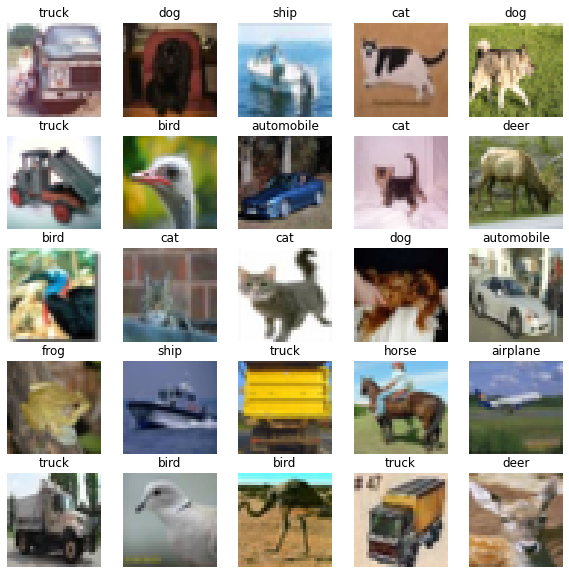

In [8]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, give_class_name(labels))

### Preprocessing the data

In [9]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## MODELS

In [10]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Normalization, Rescaling

In [11]:
MODELS_PATH = ROOT_DIR / "models"
INPUT_SHAPE = train_images.shape[1:]

In [12]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)

### Create Models

TODO List - 
   - Improve Simple Sequential Model
     - Read and see other Models
   - Add more Models
     - Model with VGG-Like Blocks
     - Model with residual Blocks
     - Model With Inseption Blocks
     - Model With Mobile Blocks
     - Transfer Learning Models
       - VGG
       - ResNet
       - Inseption
       - Mobile

#### Simple Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential

def simple_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Normalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Normalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


#### Deeper Sequential Model

In [94]:
from tensorflow.keras.models import Sequential

def deeper_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Normalization())
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Normalization())
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Normalization())
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


### Training

In [88]:
# ploting the model training history

def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


#### Simple Sequential Model

In [89]:
model = simple_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 normalization_31 (Normaliza  (None, 16, 16, 32)       65        
 tion)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 8, 8, 64)        

In [90]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/simple_sequential.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [91]:
history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/30
  1/625 [..............................] - ETA: 6:47 - loss: 2.3703 - accuracy: 0.0312

2022-06-12 13:58:47.800829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 1.6181 - accuracy: 0.4049

2022-06-12 13:58:57.367211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.54990, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 11s 17ms/step - loss: 1.6166 - accuracy: 0.4058 - val_loss: 1.2823 - val_accuracy: 0.5499
Epoch 2/30
623/625 [============================>.] - ETA: 0s - loss: 1.1956 - accuracy: 0.5744
Epoch 2: val_accuracy improved from 0.54990 to 0.62510, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 10s 17ms/step - loss: 1.1955 - accuracy: 0.5744 - val_loss: 1.0613 - val_accuracy: 0.6251
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.0111 - accuracy: 0.6448
Epoch 3: val_accuracy improved from 0.62510 to 0.63500, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 10s 17ms/ste

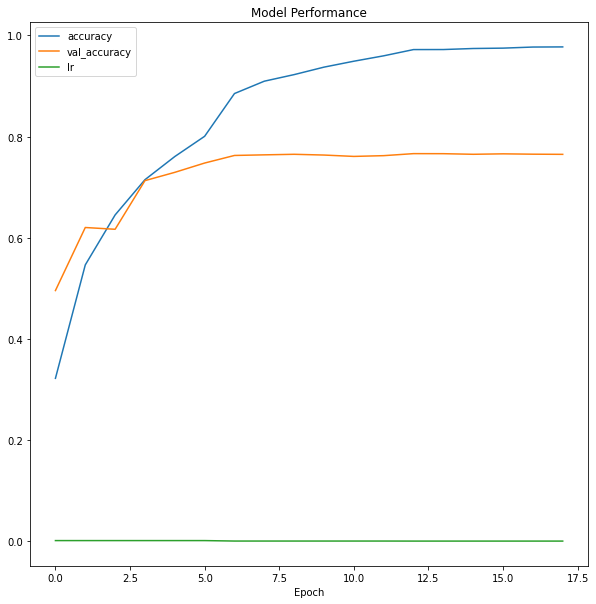

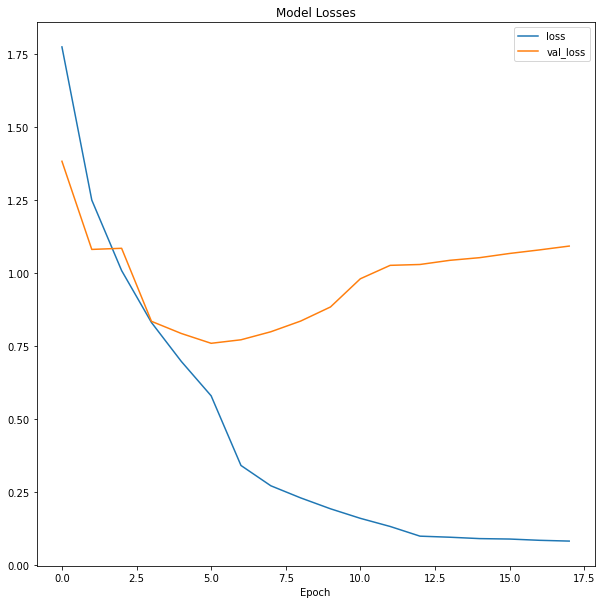

In [51]:
plot_model_performance(history)

In [52]:
model.evaluate(test_images, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 1.1947 - accuracy: 0.7536


[1.1946688890457153, 0.7536000609397888]

#### Deeper Sequential Model

In [95]:
model = deeper_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 normalization_33 (Normaliza  (None, 16, 16, 64)       129       
 tion)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 8, 8, 128)       

In [96]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/deeper_sequential.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [97]:
history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/30


2022-06-12 14:13:34.404358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


624/625 [============================>.] - ETA: 0s - loss: 1.8240 - accuracy: 0.3149

2022-06-12 14:13:51.409721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.47050, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 19s 29ms/step - loss: 1.8234 - accuracy: 0.3152 - val_loss: 1.4196 - val_accuracy: 0.4705
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.3136 - accuracy: 0.5301
Epoch 2: val_accuracy improved from 0.47050 to 0.60300, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 18s 29ms/step - loss: 1.3134 - accuracy: 0.5301 - val_loss: 1.1027 - val_accuracy: 0.6030
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 1.1041 - accuracy: 0.6102
Epoch 3: val_accuracy improved from 0.60300 to 0.66510, saving model to /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/CIFAR-10/models/simple_sequential.h5
625/625 [==============================] - 18s 29ms/ste

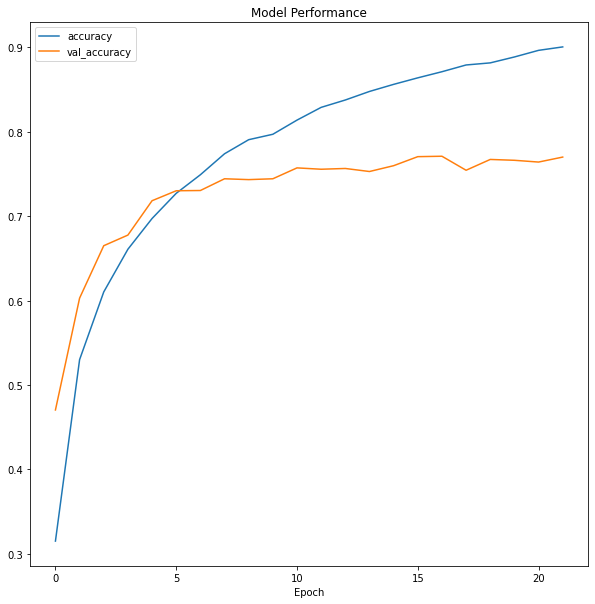

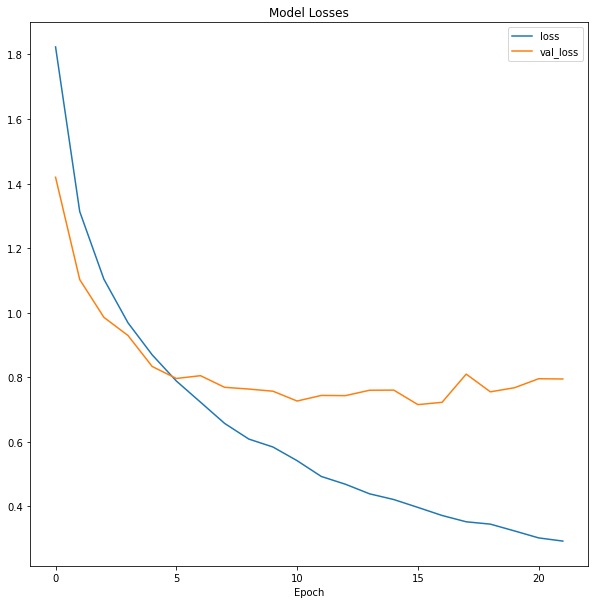

In [98]:
plot_model_performance(history)

In [100]:
model.evaluate(test_images, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.8484 - accuracy: 0.7587


[0.8484305143356323, 0.7587000131607056]

## Testing Performance

In [82]:
from sklearn.metrics import confusion_matrix, classification_report 

def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
        
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    if labels:
        cr = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
        
    plt.show()

### Simple Sequential Model

In [83]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/simple_sequential.h5')

#### Performance Heatmap

2022-06-12 13:56:11.751298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.7533


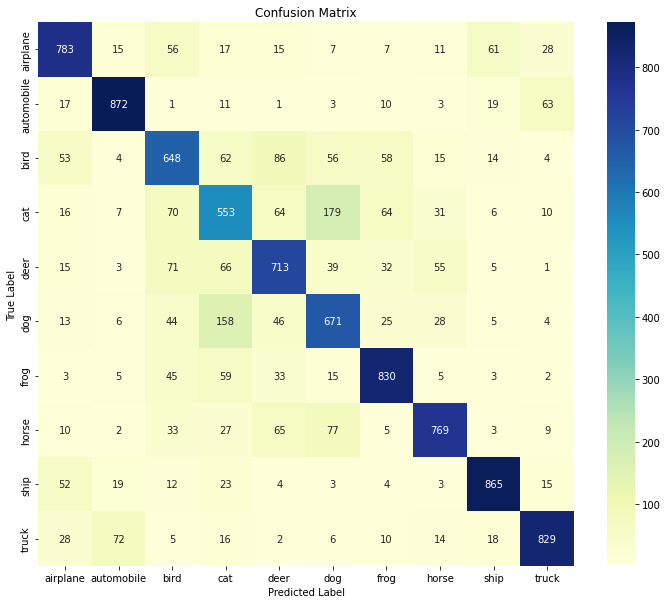

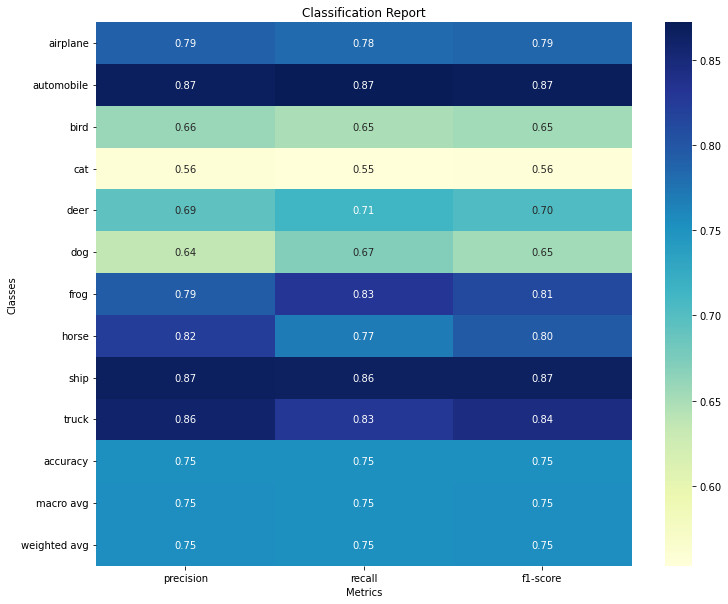

In [84]:
#  confusion matrix and classification report
from sklearn.metrics import accuracy_score

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)
print("Accuracy:", accuracy_score(y, test_labels_pred))
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)


#### Data Visualization

In [61]:
test_labels

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

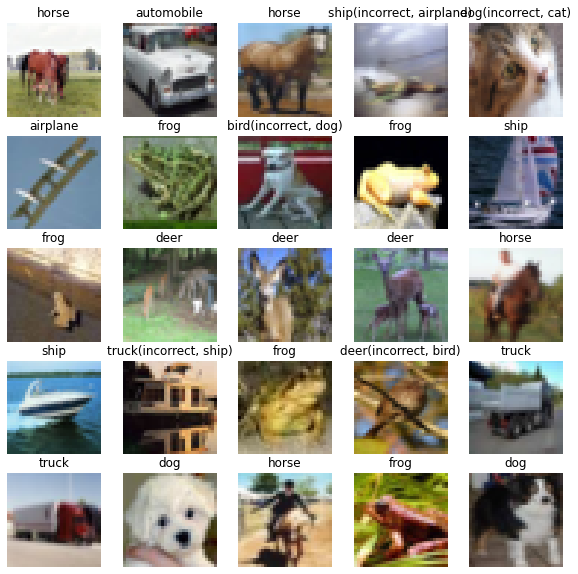

In [62]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


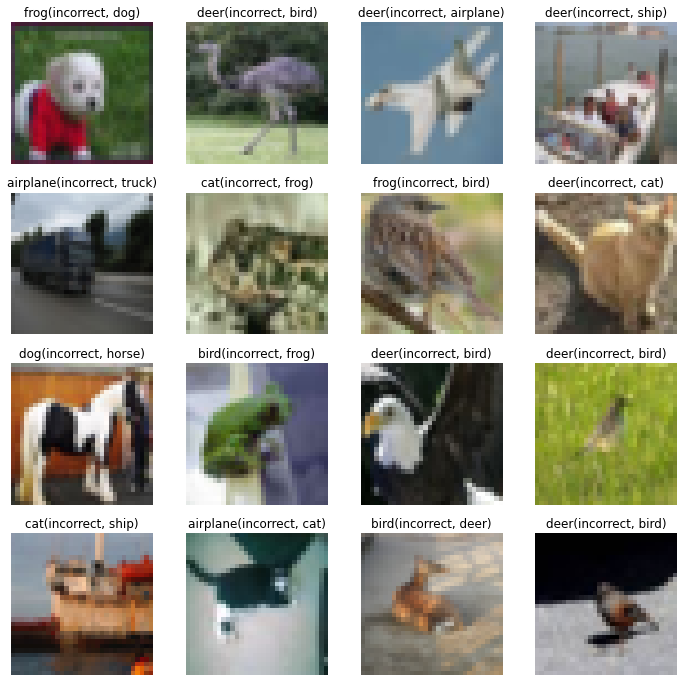

In [63]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

### Deeper Sequential Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/deeper_sequential.h5')

#### Performance Heatmap

2022-06-12 13:56:11.751298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.7533


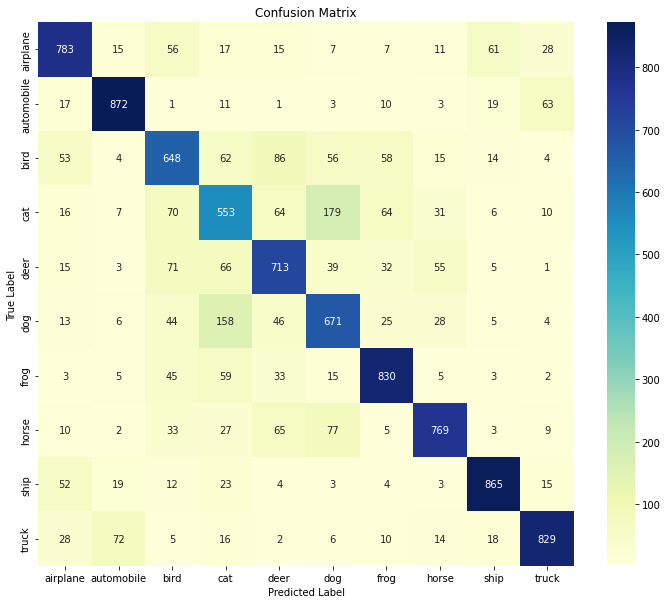

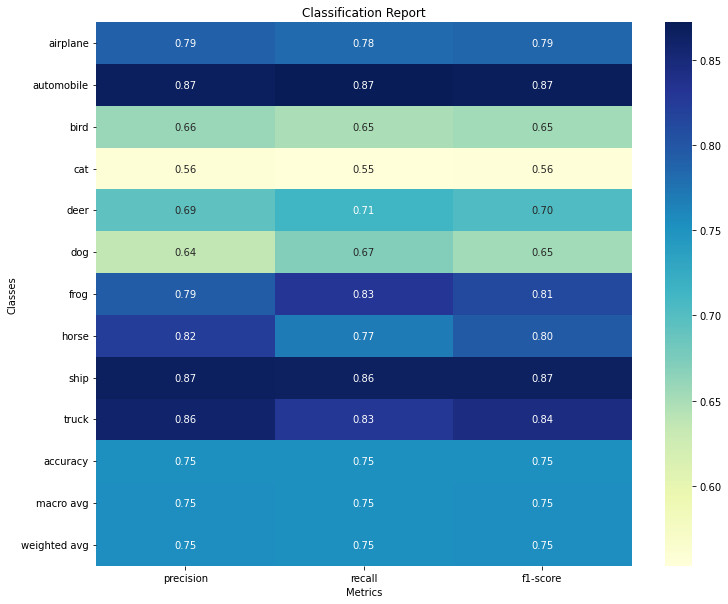

In [ ]:
#  confusion matrix and classification report
from sklearn.metrics import accuracy_score

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)
print("Accuracy:", accuracy_score(y, test_labels_pred))
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)


#### Data Visualization

In [ ]:
test_labels

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

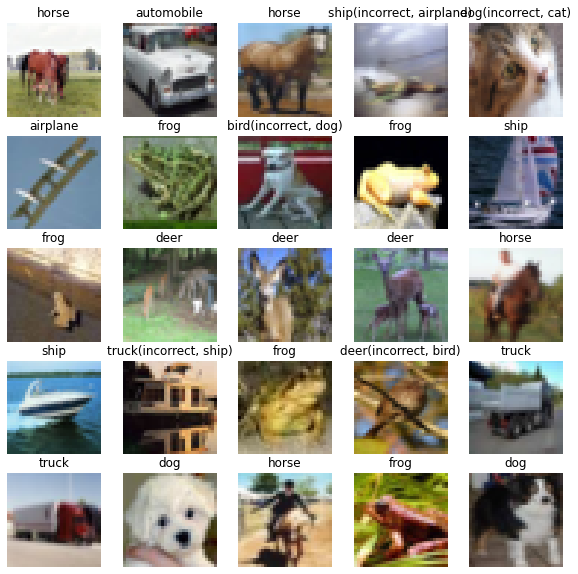

In [ ]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


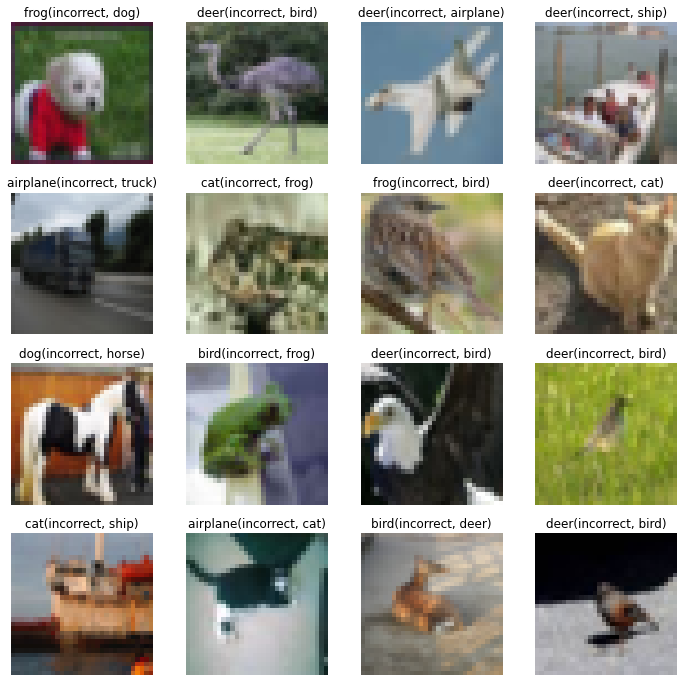

In [ ]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

## Results

### 75% is not good enough accuracy, Will apply more models untill we get good results

### Simple Sequential Model with Dropout

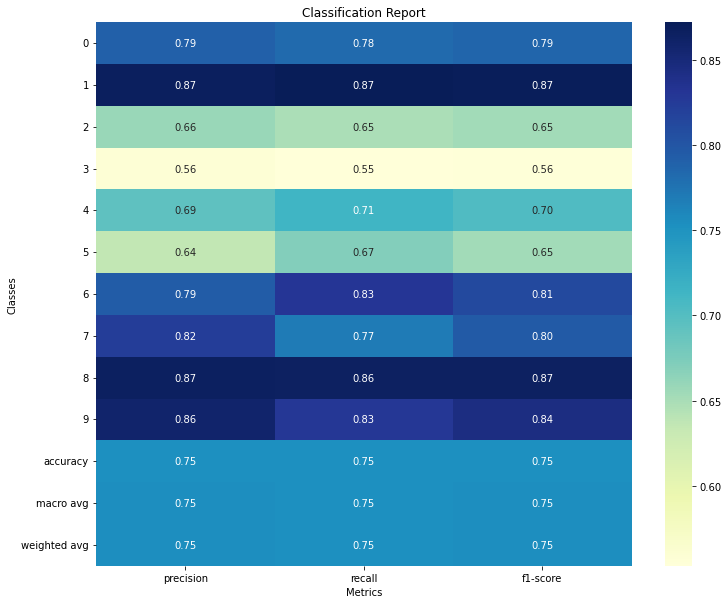

In [64]:
classification_report_plot(y, test_labels_pred)